## Radio interferometría y síntesis de imágenes en astronomía - Laboratorio 1
### Vicente Mieres

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, timezone
import juliandate as jd

## Funciones y utilidades

### Funciones principales

In [ ]:
def ecef_to_enu(ecef, array_center, phi=-33.45, lamb=-70.66, rad=True, is_array=True):
  '''
  ecef in meters (xyz)
  array_center: central antenna coords
  phi: latitud
  lamb (lambda): longitude
  rad: True if phi and lambd need to be radians
  '''
  if rad:
      phi, lamb = np.deg2rad(phi), np.deg2rad(lamb)

  cphi, clam = np.cos(phi), np.cos(lamb)
  sphi, slam = np.sin(phi), np.sin(lamb)


  R = np.array([[-slam,        clam,       0],
                [-clam*sphi,   -slam*sphi, cphi],
                [clam*cphi,    slam*cphi,  sphi]])

  dxyz = np.array(ecef) - np.array(array_center)

  enu = R @ dxyz.T if is_array else R @ dxyz

  return enu


def enu_to_altaz(enu, rad=True, is_array=True):
  '''
  Transform the enu vector to altitude and azimut
  '''

  if is_array:
    E, N, U = enu[0], enu[1], enu[2]
  else:
    E, N, U = float(enu[0]), float(enu[1]), float(enu[2])

  r = np.hypot(E, N)           
  El = np.arctan2(U, r)
  A = np.arctan2(E, N)
  
  if rad:
      return El, A % (2*np.pi)
  else:
      A_deg = np.degrees(A) % 360.0
      El_deg = np.degrees(El)
      return El_deg, A_deg

def local_sidereal_time(longitude=-70.76, utc=None, single=True):
  """
  Calculates the local sidereal time in Radians.
  """
  if utc is None:
    now = datetime.now(timezone.utc)
  else:
    now = utc

  jd_now = jd.from_gregorian(now.year, now.month, now.day, now.hour, now.minute, now.second)
  T = (jd_now - 2451545.0) / 36525
  theta = 280.46061837 + 360.98564736629 * (jd_now - 2451545) + (0.000387933 * T * T) - (T * T * T / 38710000.0)
  deg = theta % 360 + longitude

  h,m,s = degree_to_time(deg)
  rad = np.deg2rad(deg)
  
  if single: 
    return rad 
  else: 
    return deg, rad, h, m, s

def degree_to_time(theta, is_rad=False):
  """
  Converts degrees to hours, minutes and seconds.
  """
  if is_rad:
    theta = np.rad2deg(theta)

  h = int(theta/ 15)
  m = (int)(((theta / 15) - h) * 60)
  s = ((((theta / 15) - h) * 60) - m) * 60
  return h, m, s

def Rz(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, -s, 0],
                   [ s, c, 0],
                   [ 0, 0, 1]])

def Ry(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, 0, s],
  [ 0, 1, 0],
  [-s, 0, c]])


def hor_to_eq(enu, alt, az, phi=-33.45):
    """
    Convierte un baseline ENU en coordenadas ecuatoriales (X, Y, Z),
    equivalente a baseline_to_XYZ().

    Parámetros
    ----------
    enu : array (..., 3)
        Coordenadas de baselines en el sistema local (E, N, U)
    alt, az : array o float
        Ángulos de elevación y acimut de la fuente (radianes)
    phi : float
        Latitud del observatorio (radianes)
    Retorna
    -------
    r_eq : array (..., 3)
        Coordenadas ecuatoriales (X, Y, Z)
    """
    phi = np.radians(phi)

    # Convertir a np.array y asegurar forma (...,3)
    enu = np.asarray(enu)
    if enu.shape[-1] != 3:
        raise ValueError("El array ENU debe tener forma (..., 3)")

    # Separar componentes
    E, N, U = enu[..., 0], enu[..., 1], enu[..., 2]

    # Norma del baseline
    b_norm = np.sqrt(E**2 + N**2 + U**2)

    # Calcular X, Y, Z (idéntico a baseline_to_XYZ)
    X = b_norm * ( np.sin(alt)*np.cos(phi) - np.cos(alt)*np.sin(phi)*np.cos(az) )
    Y = b_norm * ( np.sin(az)*np.cos(alt) )
    Z = b_norm * ( np.sin(alt)*np.sin(phi) + np.cos(alt)*np.cos(phi)*np.cos(az) )

    return np.stack([X, Y, Z], axis=-1)


def eq_to_uvw(H, delta, hor_coords, is_array=True):
  '''
  Return the uvw coords of an antenna o antenna array 
  '''
  ch, cd = np.cos(H), np.cos(delta)
  sh, sd = np.sin(H), np.sin(delta)

  R = np.array([[sh,        ch,      0],
                [-sd*ch,   sd*sh,   cd],
                [cd*ch,   -cd*ch,   sd]])
  
  uvw = hor_coords @ R.T if is_array else R @ hor_coords

  return uvw

def baselines(enu):
  '''
  Return all combinations of baselines
  '''
  enu = np.asarray(enu)
  N = len(enu)

  # Matriz completa de diferencias (N, N, 3)
  diff = enu[:, None, :] - enu[None, :, :]

  # Evitar la diagonal (i == j)
  mask = ~np.eye(N, dtype=bool)
  baselines = diff[mask].reshape(-1, 3)

  return baselines

def eq_to_uvw_array(H_array, delta, r_eq):
    """
    Aplica la rotación (Ecuación 4) a todos los baselines y horas ángulo.
    r_eq: (N_baselines, 3)
    H_array: (N_H,)
    delta: float (rad)
    Retorna: uvw (N_baselines, N_H, 3)
    """
    cd, sd = np.cos(delta), np.sin(delta)
    ch, sh = np.cos(H_array), np.sin(H_array)

    # Matrices de rotación para cada H  → forma (N_H, 3, 3)
    R = np.stack([
        np.stack([sh,        ch,        np.zeros_like(H_array)], axis=-1),
        np.stack([-sd*ch,    sd*sh,     np.full_like(H_array, cd)], axis=-1),
        np.stack([cd*ch,    -cd*sh,     np.full_like(H_array, sd)], axis=-1)
    ], axis=-2)  # axis=-2 -> (N_H, 3, 3)
    
    uvw = np.einsum('hij,bj->bhi', R, r_eq)  # (N_baselines, N_H, 3)

    return uvw

def ra_dec_to_radians(radec, is_ra=True):
  """
  Converts right ascension and declination to Radians.
  """
  h, m, s = map(float, (radec.split(':')))
  
  value = abs(h) + m / 60 + s / 3600
  if is_ra:
    degrees = value * 15
  else:
    degrees = value if h >= 0 else -value
  return np.deg2rad(degrees)


def uvw_to_lambda(uvw, freq_hz):
    """
    Convierte las coordenadas UVW de metros a longitudes de onda (λ).
    """
    c = 299792458.0  # velocidad de la luz (m/s)
    lam = c / freq_hz
    uvw_lambda = uvw / lam
    return uvw_lambda, lam

def plot_uv_coverage(
    uvw,
    unit="m",
    freq_hz=100e9,
    title=None,
    show_symmetry=True,
    show_center=True,
    center_color="white",
    center_size=50,
    color="deepskyblue",
    symmetry_color=None,
    cmap=None,
    color_by=None
):
    """
    Grafica la cobertura (u,v) para diferentes unidades y opciones de color.

    Parámetros
    ----------
    uvw : array (..., 3)
        Coordenadas UVW en metros.
    unit : str
        Unidad del gráfico: "m", "km" o "lambda".
    freq_hz : float
        Frecuencia (solo usada si unit="lambda").
    title : str
        Título opcional del gráfico.
    show_symmetry : bool
        Si True, grafica también la parte negativa (-u, -v).
    show_center : bool
        Si True, muestra un punto central.
    center_color : str
        Color del punto central.
    center_size : int
        Tamaño del punto central.
    color : str o array
        Color base de los puntos (nombre o array numérico).
    symmetry_color : str
        Color de la simetría (por defecto más tenue del color base).
    cmap : str
        Colormap opcional si `color_by` es numérico.
    color_by : array (...,)
        Array para colorear los puntos según algún valor (por ejemplo, hora angular).
    """
    # --- Selección de unidades ---
    if unit == "m":
        scale = 1.0
        label = "[m]"
    elif unit == "km":
        scale = 1e-3
        label = "[km]"
    elif unit.lower() in ["λ", "lambda", "wavelength"]:
        uvw, lam = uvw_to_lambda(uvw, freq_hz)
        scale = 1.0
        label = "[λ]"
    else:
        raise ValueError("Unidad no reconocida. Usa 'm', 'km' o 'lambda'.")

    # --- Extraer u,v ---
    u = uvw[..., 0] * scale
    v = uvw[..., 1] * scale

    # --- Determinar color ---
    if symmetry_color is None:
        # Genera un color más oscuro para la parte simétrica
        if isinstance(color, str):
            symmetry_color = "royalblue" if color == "deepskyblue" else color
        else:
            symmetry_color = color

    # --- Crear figura ---
    plt.figure(figsize=(6, 6))

    # Si se quiere colorear por una variable
    if color_by is not None:
        sc = plt.scatter(u.flatten(), v.flatten(), c=color_by.flatten(),
                         s=2, cmap=cmap or "viridis", label="Baselines")
        plt.colorbar(sc, label="Color variable")
    else:
        plt.plot(u.flatten(), v.flatten(), ".", markersize=1, color=color, label="Baselines")

    if show_symmetry:
        plt.plot(-u.flatten(), -v.flatten(), ".", markersize=1,
                 alpha=0.4, color=symmetry_color, label="Simetría conjugada")

    # --- Punto central ---
    if show_center:
        plt.scatter(0, 0, color=center_color, s=center_size, zorder=5)

    plt.xlabel(f"u {label}")
    plt.ylabel(f"v {label}")
    plt.axis("equal")
    plt.grid(alpha=0.2)
    plt.legend(markerscale=5, fontsize=8, loc="upper right")

    if title:
        plt.title(title)
    else:
        plt.title(f"Cobertura UV ({unit})")

    plt.show()


def H_range(ra_rad, utc_start, utc_end, longitude=-70.76, step_minutes=5):
    """
    Calcula una serie de Hora Angular (H) física entre dos fechas UTC.

    Parámetros
    ----------
    ra_rad : float
        Ascensión recta de la fuente en radianes.
    utc_start : str o datetime
        Fecha/hora de inicio (ej: "2025-10-10 00:00:00").
    utc_end : str o datetime
        Fecha/hora de fin (ej: "2025-10-10 06:00:00").
    longitude : float
        Longitud del observatorio (grados, Oeste negativo).
    step_minutes : float
        Paso temporal entre muestras en minutos.
    """

    # --- Parsear las fechas si vienen como strings ---
    if isinstance(utc_start, str):
        utc_start = datetime.fromisoformat(utc_start).replace(tzinfo=timezone.utc)
    if isinstance(utc_end, str):
        utc_end = datetime.fromisoformat(utc_end).replace(tzinfo=timezone.utc)

    # --- Crear el rango de tiempos ---
    n_steps = int((utc_end - utc_start).total_seconds() / 60 / step_minutes) + 1
    times_utc = [utc_start + timedelta(minutes=i * step_minutes) for i in range(n_steps)]

    # --- Calcular LST para cada instante ---
    lst_rad = np.array([
        local_sidereal_time(longitude=longitude, utc=t, single=True)
        for t in times_utc
    ])

    # --- Calcular H = LST - RA ---
    H = lst_rad - ra_rad

    # --- Envolver a (-π, π] ---
    H = (H + np.pi) % (2 * np.pi) - np.pi

    return times_utc, H, lst_rad


### Funciones secundarias

In [45]:
# utilidades 

def read_cfg_to_enu(filename, array_center=None ,phi=-33.44, lamb=-70.76, rad=True):
  '''
  Read file and return antenna config on ENU coords
  '''
  with open(filename, "r") as f:
    lines = f.readlines()

  coordsys = None 
  for line in lines:
        if line.startswith("# coordsys"):
            coordsys = line.split("=")[1].strip()
            break
  
  antennas = []
  for line in lines:
      if line.startswith("#") or not line.strip():
          continue
      parts = line.split()
      x, y, z = map(float, parts[:3])
      antennas.append([x, y, z])
  antennas = np.array(antennas)

  if coordsys == "LOC (local tangent plane)": return antennas.T
  elif coordsys == "XYZ":
     array_center = array_center if array_center is not None else antennas.mean(axis=0)
     enu_antennas = ecef_to_enu(antennas, array_center, phi, lamb, rad)
     return np.array(enu_antennas)
  else:
    raise ValueError(f"coordsys desconocido: {coordsys}")

import numpy as np
import matplotlib.pyplot as plt

def plot_antennas(enu_coords, labels=True, title="Configuración de Antenas", unit="m"):
    """
    Muestra la configuración de antenas a partir de sus coordenadas ENU.

    Parámetros
    ----------
    enu_coords : ndarray (N,3)
        Arreglo con las coordenadas [E, N, U] de cada antena (en metros).
    labels : bool
        Si True, muestra el índice de cada antena en el gráfico.
    title : str
        Título del gráfico.
    unit : {"m", "km"}
        Unidad en la que se mostrarán las coordenadas en el gráfico.
        Siempre se asume que enu_coords está en metros internamente.
    """

    enu_coords = np.array(enu_coords)

    # --- Conversión de unidades ---
    if unit == "m":
        scale = 1
        unit_label = "m"
    elif unit == "km":
        scale = 1e-3
        unit_label = "km"
    else:
        raise ValueError(f"Unidad desconocida: {unit}. Usa 'm' o 'km'.")

    E, N, U = enu_coords[:, 0] * scale, enu_coords[:, 1] * scale, enu_coords[:, 2] * scale

    # --- Gráfico ---
    fig = plt.figure(figsize=(12, 6))

    # Vista en planta (E-N)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(E, N, c='black', marker='o')
    if labels:
        for i, (e, n) in enumerate(zip(E, N)):
            ax1.text(e, n, str(i), fontsize=9, ha='right')
    ax1.set_xlabel(f"East [{unit_label}]")
    ax1.set_ylabel(f"North [{unit_label}]")
    ax1.set_title("Vista en planta (E-N)")
    ax1.grid(True)
    ax1.axis('equal')

    # Vista en perfil (N-U)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(N, U, c='darkblue', marker='o')
    if labels:
        for i, (n, u) in enumerate(zip(N, U)):
            ax2.text(n, u, str(i), fontsize=9, ha='right')
    ax2.set_xlabel(f"North [{unit_label}]")
    ax2.set_ylabel(f"Up [{unit_label}]")
    ax2.set_title("Vista en perfil (N-U)")
    ax2.grid(True)
    ax2.axis('equal')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



### Catálogo de Fuentes

In [41]:
catalog = {
        'Sirius': {'RA': '06:45:09', 'Dec': '-16:42:58'},
        'Canopus': {'RA': '06:23:57', 'Dec': '-52:41:44'},
        'Centauri': {'RA': '14:39:36', 'Dec': '-60:50:02'},
        'Betelgeuse': {'RA': '05:55:10', 'Dec': '+07:24:25'},
        'Rigel': {'RA': '05:14:32', 'Dec': '-08:12:06'},
        'M31': {'RA': '00:42:44.3', 'Dec': '+41:16:09'},
        'M42': {'RA': '05:35:17.3', 'Dec': '-05:23:28'},
        '47_Tuc': {'RA': '00:24:05', 'Dec': '-72:04:52'},
        'LMC': {'RA': '05:23:35', 'Dec': '-69:45:22'}
    }

## Parte 1 Simulación de cobertura uv

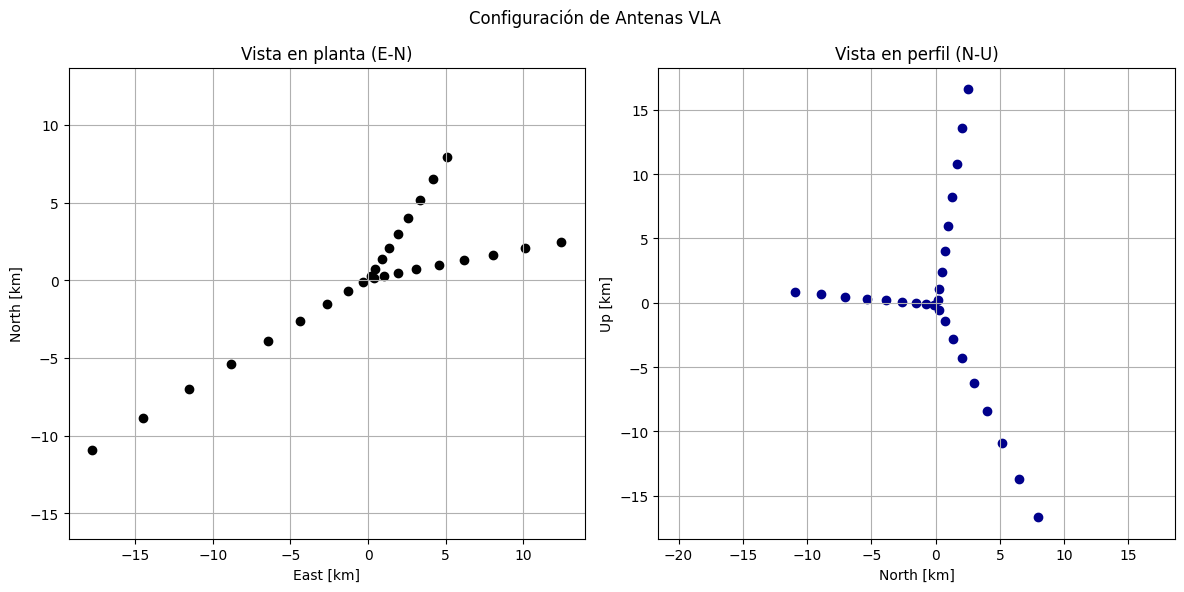

In [54]:
# 1. Lectura de antenas y definición de parámetros del arreglo
# Observatory VLA

latitude = 34.078749
longitude = -107.617728

enu = read_cfg_to_enu("../antenna_arrays/vla.a.cfg")

plot_antennas(enu.T, labels=False, unit="km",title="Configuración de Antenas VLA")

In [56]:
# 2. Obtención de Baselines
baselines_enu = baselines(enu.T) 

print("Baselines: ", baselines_enu.shape)

Baselines:  (702, 3)


In [60]:
# 3. Transformacion baseline -> alt, az (Horizontales) -> XYZ (Ecuatoriales)
alt, az = enu_to_altaz(baselines_enu.T, rad=True)
r_eq = hor_to_eq(baselines_enu, alt, az, phi=latitude)

print("Altitud: ", alt.shape) 
print("Azimut: ", az.shape) 
print("XYZ: ", r_eq.shape) 


Altitud:  (702,)
Azimut:  (702,)
XYZ:  (702, 3)


In [86]:
# Ascensión recta del objeto (por ejemplo 5h 20m 0s)
ra_h = 5 + 20/60
ra_rad = np.deg2rad(ra_h * 15)

times_utc, H, lst = hour_angle_from_utc_range(
    ra_rad=ra_rad,
    utc_start="2025-10-10 00:00:00",
    utc_end="2025-10-10 12:00:00",
    longitude=-70.76,
    step_minutes=5
)

print("Primeras 5 horas angulares (rad):", len(H))



Primeras 5 horas angulares (rad): 145


In [ ]:
# 4. Transformación XYZ -> uvw

# Delta fijo -> Sirius
sirius_dec = catalog["Sirius"]['Dec']
delta0 = ra_dec_to_radians(sirius_dec, is_ra=False)

# Rango de horas angulo
# H = H_range(-13, 6, 100)

# Obtención muestreo
uvw = eq_to_uvw_array(H, delta0, r_eq)

print("uvw:", uvw.shape)

uvw: (702, 100, 3)


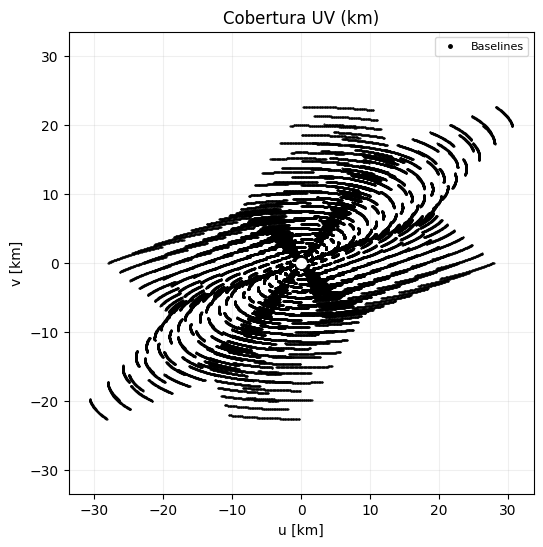

In [78]:
# 5. Gráfico uvw
plot_uv_coverage(uvw, unit='km', show_center=True, show_symmetry=False, color='black')